In [36]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

In [37]:

def load_data(file_path, delimiter=';'):
    """
    Loads CSV data.
    Assumes that the CSV has a header row.
    """
    df = pd.read_csv(file_path, delimiter=delimiter)
    # Ensure that the timestamp column is treated as a numeric (or datetime, if applicable)
    df['timestamp'] = pd.to_numeric(df['timestamp'], errors='coerce')
    return df

In [38]:
def compute_weighted_asset_series(df, asset, weight, time_col='timestamp', price_col='price'):
    """
    For a given asset, computes the average traded price per timestamp,
    multiplies it by the asset's weight and returns a series.
    """
    asset_df = df[df['symbol'] == asset]
    # Average price per timestamp – you may use other aggregation (e.g. volume-weighted average) if needed.
    avg_price = asset_df.groupby(time_col)[price_col].mean()
    return avg_price * weight

In [39]:
def compute_basket_price(df, basket_composition, time_col='timestamp', price_col='price'):
    """
    Computes a synthetic basket price time series by combining the underlying asset prices.
    basket_composition is a dictionary where the keys are asset names and the values are the weights.
    E.g. for PICNIC_BASKET1: {'CROISSANTS': 6, 'JAMS': 3, 'DJEMBES': 1}
    """
    basket_series = None
    # Loop through each asset in the basket composition
    for asset, weight in basket_composition.items():
        series = compute_weighted_asset_series(df, asset, weight, time_col, price_col)
        if basket_series is None:
            basket_series = series
        else:
            basket_series = basket_series.add(series, fill_value=0)
    basket_series.sort_index(inplace=True)
    return basket_series

In [40]:
def plot_time_series(series_dict, title='Time Series', xlabel='Timestamp', ylabel='Price'):
    """
    Plots multiple time series on the same figure.
    series_dict should be a dictionary with labels as keys and Pandas Series as values.
    """
    plt.figure(figsize=(12, 6))
    for label, series in series_dict.items():
        plt.plot(series.index, series.values, label=label)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [41]:
import matplotlib.pyplot as plt

def plot_spread_zscore(computed_basket, instrument_series, title='Spread and Z-Score'):
    """
    Computes and plots the spread between the computed basket price and the basket instrument price,
    and also computes the z-scores of the spread.
    
    This function generates two subplots in one window:
    1. The raw price spread.
    2. The z-score (standard deviations) of the spread.
    
    Parameters:
    - computed_basket: Pandas Series representing the computed basket price time series.
    - instrument_series: Pandas Series representing the traded basket instrument price time series.
    - title: Title for the overall figure.
    """
    # Align the two series based on their common timestamps.
    common_index = computed_basket.index.intersection(instrument_series.index)
    computed_common = computed_basket.loc[common_index]
    instrument_common = instrument_series.loc[common_index]
    
    # Compute the raw spread.
    spread = instrument_common - computed_common
    
    # Compute the mean and standard deviation, and then the z-scores.
    spread_mean = spread.mean()
    spread_std = spread.std()
    z_scores = (spread - spread_mean) / spread_std if spread_std != 0 else spread - spread_mean
    
    # Create two subplots: one for raw spread and one for z-scores.
    fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    ax[0].plot(common_index, spread, label='Raw Spread', color='blue')
    ax[0].set_title('Raw Price Spread')
    ax[0].set_ylabel('Price Difference')
    ax[0].legend()
    ax[0].grid(True)
    
    ax[1].plot(common_index, z_scores, label='Spread Z-Score', color='green')
    # Add a horizontal line at 0 for reference.
    ax[1].axhline(0, color='black', linestyle='--')
    ax[1].set_title('Spread Z-Score')
    ax[1].set_xlabel('Timestamp')
    ax[1].set_ylabel('Standard Deviations (Z-Score)')
    ax[1].legend()
    ax[1].grid(True)
    
    fig.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [42]:
def clustering_analysis(time_series, n_clusters=3):
    """
    Performs clustering on basket returns.
    Uses simple percentage change (returns) as features.
    Returns the cluster labels and displays a PCA plot.
    """
    # Compute returns (percentage change)
    returns = time_series.pct_change().dropna().values.reshape(-1, 1)
    
    # Clustering with KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(returns)
    
    # Use PCA for visualisation – here, just for demonstration with one feature.
    pca = PCA(n_components=1)
    components = pca.fit_transform(returns)
    
    plt.figure(figsize=(12, 6))
    plt.scatter(range(len(returns)), returns, c=clusters, cmap='viridis', label='Returns')
    plt.title('Clustering of Basket Returns')
    plt.xlabel('Time Index')
    plt.ylabel('Returns')
    plt.colorbar(label='Cluster')
    plt.show()
    
    return clusters

In [43]:
def linear_regression_analysis(computed_series, instrument_series):
    """
    Performs a linear regression to model the relationship between the computed basket price
    and the traded basket instrument price.
    Also plots the regression line against the actual data points.
    """
    # Align the two series on the common timestamps.
    common_index = computed_series.index.intersection(instrument_series.index)
    X = computed_series.loc[common_index].values.reshape(-1, 1)
    y = instrument_series.loc[common_index].values
    
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)
    
    print("Linear regression coefficient: {:.4f}".format(model.coef_[0]))
    print("Intercept: {:.4f}".format(model.intercept_))
    
    plt.figure(figsize=(12, 6))
    plt.scatter(X, y, label='Actual Data', alpha=0.6)
    plt.plot(X, y_pred, color='red', label='Regression Line')
    plt.xlabel('Computed Basket Price')
    plt.ylabel('Traded Basket Price')
    plt.title('Linear Regression Analysis')
    plt.legend()
    plt.show()

In [44]:
trades_file = '../data/round2/basket/trades_round_2_day_1.csv'
trades_df = load_data(trades_file)

picnic_basket1_comp = {'CROISSANTS': 6, 'JAMS': 3, 'DJEMBES': 1}
picnic_basket2_comp = {'CROISSANTS': 4, 'JAMS': 2}

In [45]:
basket1_computed = compute_basket_price(trades_df, picnic_basket1_comp, time_col='timestamp', price_col='price')
basket2_computed = compute_basket_price(trades_df, picnic_basket2_comp, time_col='timestamp', price_col='price')

In [46]:
basket1_instrument = trades_df[trades_df['symbol'] == 'PICNIC_BASKET1'].groupby('timestamp')['price'].mean()
basket2_instrument = trades_df[trades_df['symbol'] == 'PICNIC_BASKET2'].groupby('timestamp')['price'].mean()

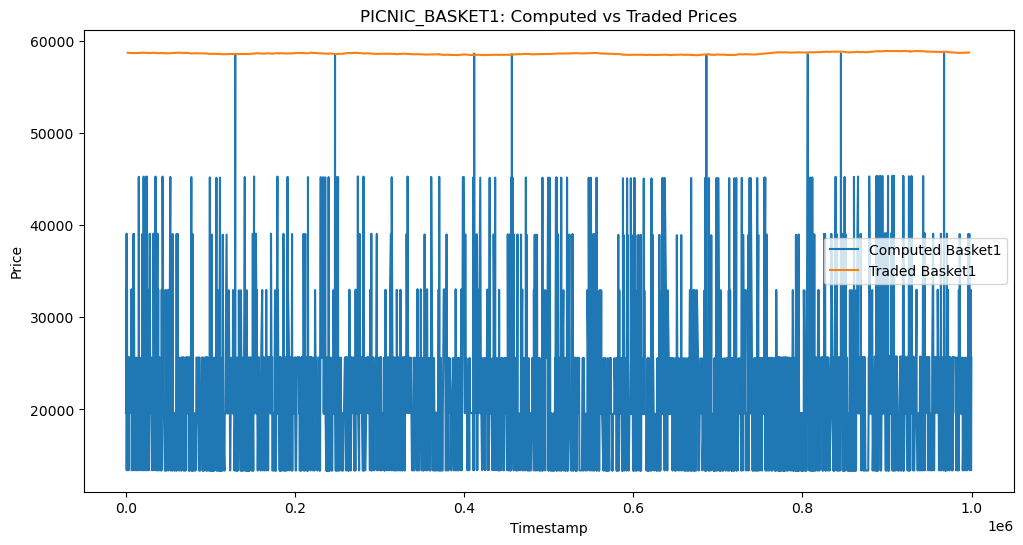

In [47]:
plot_time_series({'Computed Basket1': basket1_computed, 'Traded Basket1': basket1_instrument},
                     title='PICNIC_BASKET1: Computed vs Traded Prices')

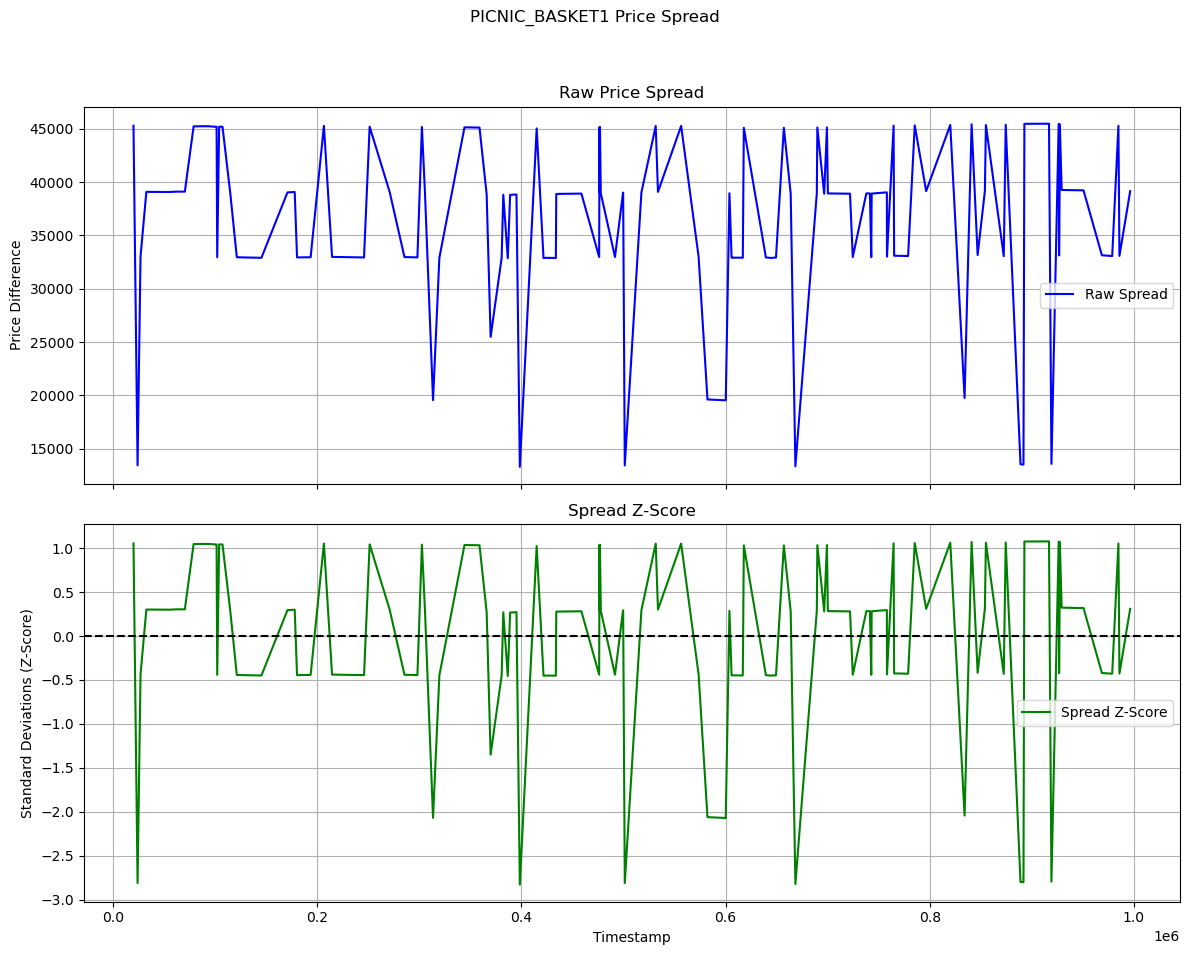

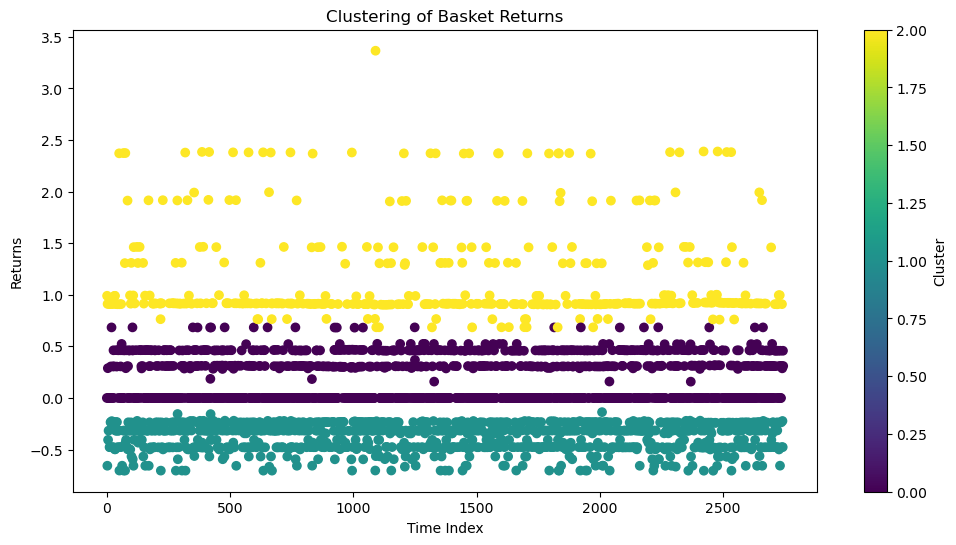

In [48]:
plot_spread_zscore(basket1_computed, basket1_instrument, title='PICNIC_BASKET1 Price Spread')
    

clusters = clustering_analysis(basket1_computed, n_clusters=3)

Linear regression coefficient: -0.0003
Intercept: 58601.9170


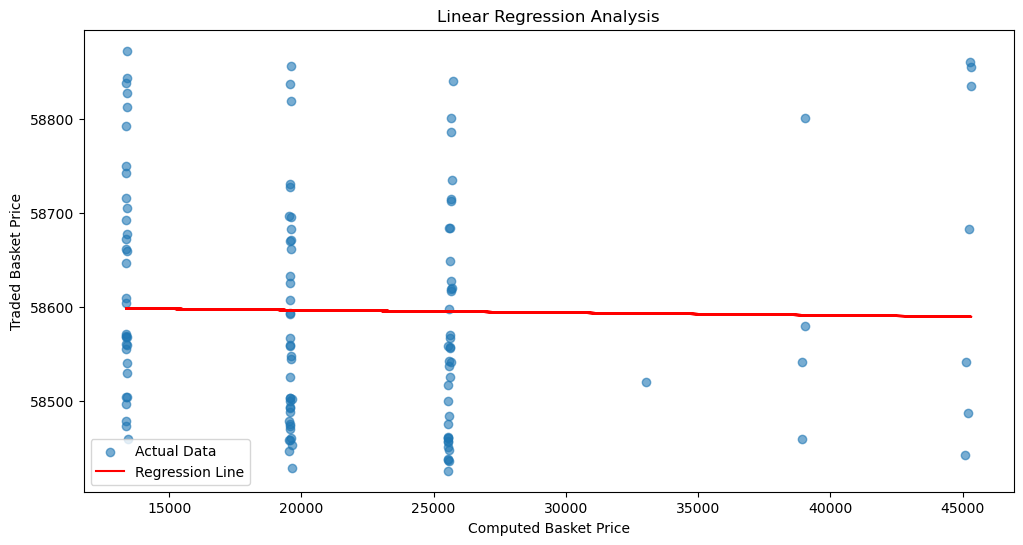

In [49]:
linear_regression_analysis(basket1_computed, basket1_instrument)

In [50]:
import numpy as np
import matplotlib.pyplot as plt

def get_pretty_ticks(spread_series, n_ticks=10):
    """
    Generates evenly spaced tick locations and formatted tick labels for a MultiIndex.
    """
    x = np.arange(len(spread_series))
    # Create tick locations (linearly spaced indices)
    if len(spread_series) > 1:
        tick_locs = np.linspace(0, len(spread_series) - 1, n_ticks, dtype=int)
    else:
        tick_locs = np.array([0])
    # Format tick labels
    tick_labels = [f"Day={spread_series.index[i][0]}, T={spread_series.index[i][1]}" for i in tick_locs]
    return x, tick_locs, tick_labels

def plot_spread_raw(spread_series, n_ticks=10):
    """
    Plots the raw spread in its own window with pretty x-axis tick labels.
    """
    x, tick_locs, tick_labels = get_pretty_ticks(spread_series, n_ticks)
    
    plt.figure(figsize=(14, 6))
    plt.plot(x, spread_series.values, label="Spread", color='blue')
    plt.xticks(tick_locs, tick_labels, rotation=45, ha='right')
    plt.title("Spread Over Time")
    plt.xlabel("Time (day, timestamp)")
    plt.ylabel("Spread")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_rolling_mean(spread_series, window=50, n_ticks=10):
    """
    Plots the rolling mean of the spread in its own window with pretty x-axis tick labels.
    """
    x, tick_locs, tick_labels = get_pretty_ticks(spread_series, n_ticks)
    rolling_mean = spread_series.rolling(window=window).mean()
    
    plt.figure(figsize=(14, 6))
    plt.plot(x, rolling_mean.values, label=f"Rolling Mean (window={window})", color='orange')
    plt.xticks(tick_locs, tick_labels, rotation=45, ha='right')
    plt.title("Rolling Mean of Spread")
    plt.xlabel("Time (day, timestamp)")
    plt.ylabel("Rolling Mean")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_rolling_std(spread_series, window=50, n_ticks=10):
    """
    Plots the rolling standard deviation of the spread in its own window with pretty x-axis tick labels.
    """
    x, tick_locs, tick_labels = get_pretty_ticks(spread_series, n_ticks)
    rolling_std = spread_series.rolling(window=window).std()
    
    plt.figure(figsize=(14, 6))
    plt.plot(x, rolling_std.values, label=f"Rolling Std (window={window})", color='green')
    plt.xticks(tick_locs, tick_labels, rotation=45, ha='right')
    plt.title("Rolling Standard Deviation of Spread")
    plt.xlabel("Time (day, timestamp)")
    plt.ylabel("Rolling Std Deviation")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


First few values of traded basket, synthetic basket, and computed spread:
               Traded Basket  Synthetic Basket  Spread
day timestamp                                         
-1  0                59289.0           59289.0     0.0
    100              59287.0           59288.5    -1.5
    200              59293.5           59290.5     3.0
    300              59293.5           59293.0     0.5
    400              59292.0           59301.5    -9.5
Augmented Dickey-Fuller Test Results:
Test Statistic: -3.1801849996300504
p-value: 0.021160682756257664
Lags Used: 3
Number of Observations Used: 29996
Critical Values: {'1%': np.float64(-3.4305680243931267), '5%': np.float64(-2.861636360888007), '10%': np.float64(-2.5668212899601888)}
Estimated half-life of mean reversion: 695.17 periods


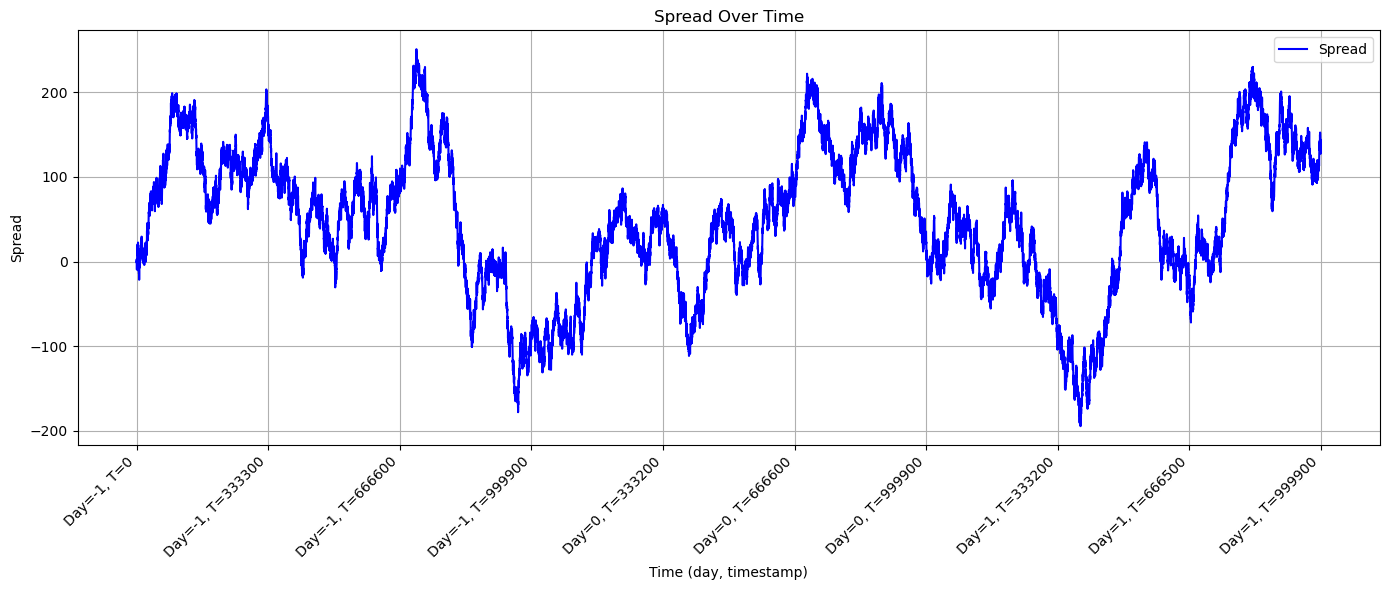

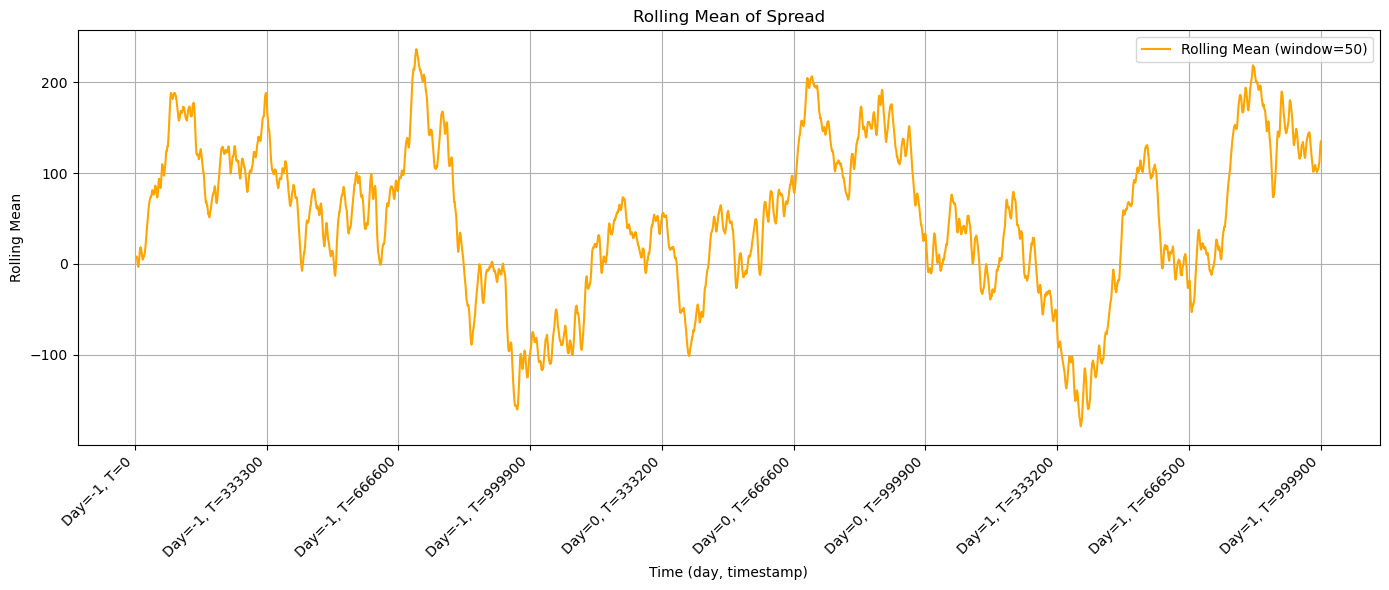

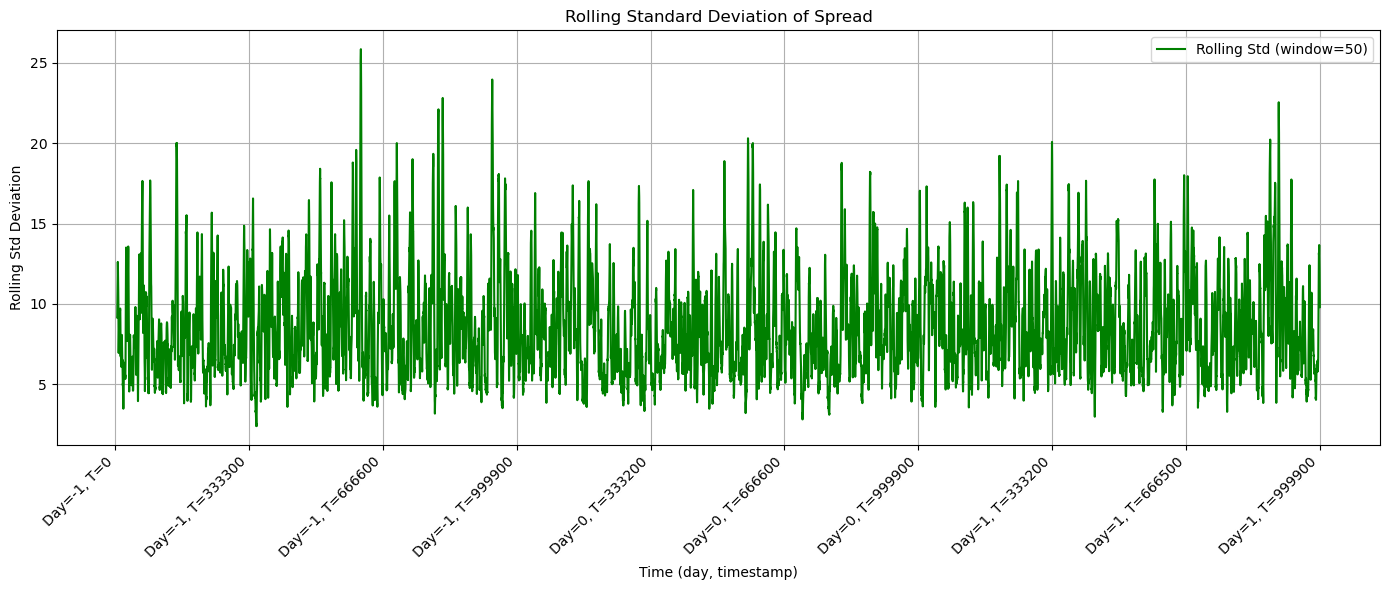


Calibrating OU parameters based on the computed spread:
OU Calibration Results:
  kappa (mean reversion speed): 0.0010
  theta (long-term mean):      53.4398
  sigma (volatility):          3.8262


In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# ----------------------------------------------------------
# 1. ADF Test Function
# ----------------------------------------------------------
def adf_test_spread(spread_series, regression='c'):
    """
    Performs the Augmented Dickey-Fuller test on a spread series.
    
    Parameters:
      spread_series (pd.Series): Time series data of the spread.
      regression (str): Type of regression for the ADF test ('c', 'ct', or 'ctt').
    
    Returns:
      result (dict): A dictionary containing the test statistic, p-value, number of lags used,
                     and critical values for the test.
    """
    result = adfuller(spread_series.dropna(), regression=regression)
    output = {
        'Test Statistic': result[0],
        'p-value': result[1],
        'Lags Used': result[2],
        'Number of Observations Used': result[3],
        'Critical Values': result[4]
    }
    print("Augmented Dickey-Fuller Test Results:")
    for key, value in output.items():
        print(f"{key}: {value}")
    return output

# ----------------------------------------------------------
# 2. Half-Life Estimation Function
# ----------------------------------------------------------
def estimate_half_life(spread_series):
    """
    Estimates the half-life of mean reversion for a spread series.
    
    This function computes a lagged version of the spread and its change (delta), 
    then regresses the delta on the lagged spread (with an intercept).
    
    The half-life is calculated as:
        half_life = -ln(2) / beta
    where beta is the slope of the regression.
    
    Parameters:
      spread_series (pd.Series): Time series data of the spread.
      
    Returns:
      half_life (float): The estimated half-life.
    """
    spread_lag = spread_series.shift(1)
    spread_delta = spread_series - spread_lag
    valid_idx = spread_lag.dropna().index
    spread_lag = spread_lag.loc[valid_idx]
    spread_delta = spread_delta.loc[valid_idx]
    spread_lag_const = sm.add_constant(spread_lag)
    model = sm.OLS(spread_delta, spread_lag_const).fit()
    beta = model.params.iloc[1]
    if beta >= 0:
        print("Warning: The beta coefficient is not negative, indicating non mean-reverting behavior.")
        return np.inf
    half_life = -np.log(2) / beta
    print(f"Estimated half-life of mean reversion: {half_life:.2f} periods")
    return half_life

# ----------------------------------------------------------
# 3. Rolling Statistics Plot Function
# ----------------------------------------------------------
# def plot_spread_rolling_statistics(spread_series, window=50, n_ticks=10):
#   """
#     Plots the spread, its rolling mean, and its rolling standard deviation with a "prettier" x-axis.
    
#     Instead of labeling every single index (day, timestamp) tuple, we choose 'n_ticks' points
#     evenly spaced along the x-axis and create nicely formatted tick labels.

#     Parameters:
#       spread_series (pd.Series): The time series data for the spread. Index should be MultiIndex (day, timestamp).
#       window (int): The window size for calculating rolling statistics (default=50).
#       n_ticks (int): Number of tick labels to show along the x-axis (default=10).
#     """
#   # Convert the index to a numeric x-axis
#   x = np.arange(len(spread_series))
  
#   # Compute rolling statistics
#   rolling_mean = spread_series.rolling(window=window).mean()
#   rolling_std = spread_series.rolling(window=window).std()
  
#   # Decide how many points we want along the x-axis
#   # We'll linearly space from 0 to len(spread_series) - 1
#   # Example: n_ticks=10 means we place 10 ticks along the x-axis.
#   if len(spread_series) > 1:
#       tick_locs = np.linspace(0, len(spread_series) - 1, n_ticks, dtype=int)
#   else:
#       tick_locs = np.array([0])
  
#   # Build the tick labels, e.g. "Day=-1, T=100"
#   tick_labels = []
#   for loc in tick_locs:
#       # Grab the corresponding MultiIndex tuple (day, timestamp)
#       day_val, time_val = spread_series.index[loc]
#       tick_labels.append(f"Day={day_val}, T={time_val}")
  
#   # Plotting
#   plt.figure(figsize=(14, 8))
  
#   # 1. Plot the raw spread
#   plt.subplot(3, 1, 1)
#   plt.plot(x, spread_series.values, label="Spread", color='blue')
#   plt.xticks(tick_locs, tick_labels, rotation=45, ha='right')
#   plt.title("Spread Over Time")
#   plt.ylabel("Spread")
#   plt.legend()
#   plt.grid(True)
  
#   # 2. Plot the rolling mean
#   plt.subplot(3, 1, 2)
#   plt.plot(x, rolling_mean.values, label=f"Rolling Mean (window={window})", color='orange')
#   plt.xticks(tick_locs, tick_labels, rotation=45, ha='right')
#   plt.title("Rolling Mean of Spread")
#   plt.ylabel("Rolling Mean")
#   plt.legend()
#   plt.grid(True)
  
#   # 3. Plot the rolling standard deviation
#   plt.subplot(3, 1, 3)
#   plt.plot(x, rolling_std.values, label=f"Rolling Std (window={window})", color='green')
#   plt.xticks(tick_locs, tick_labels, rotation=45, ha='right')
#   plt.title("Rolling Standard Deviation of Spread")
#   plt.xlabel("Time (day, timestamp)")
#   plt.ylabel("Rolling Std Deviation")
#   plt.legend()
#   plt.grid(True)
  
#   plt.tight_layout()
#   plt.show()

# ----------------------------------------------------------
# 4. Helper: Compute Synthetic Basket Price
# ----------------------------------------------------------
def compute_synthetic_basket(underlying_df, composition, constant_offset=0.0):
    """
    Computes the synthetic basket price based on a DataFrame of asset mid prices,
    the given basket composition, and a constant offset.
    
    Parameters:
      underlying_df (pd.DataFrame): DataFrame with asset mid prices. Columns must match asset names.
      composition (dict): Dictionary of asset weights (e.g., {'CROISSANTS': 6, 'JAMS': 3, 'DJEMBES': 1}).
      constant_offset (float): Calibration constant.
      
    Returns:
      synthetic_series (pd.Series): Synthetic basket price time series.
    """
    synthetic_series = pd.Series(0, index=underlying_df.index, dtype=float)
    for asset, weight in composition.items():
        synthetic_series += underlying_df[asset] * weight
    synthetic_series += constant_offset
    return synthetic_series

# ----------------------------------------------------------
# 5. OU Parameter Calibration Routine
# ----------------------------------------------------------
def calibrate_ou_params(series, dt=1.0):
    """
    Calibrates the parameters of an Ornstein-Uhlenbeck process (kappa, theta, sigma)
    from a given time series.
    
    The discrete OU process is:
        X_{t+1} = X_t + kappa*(theta - X_t)*dt + sigma*ε_t,
    which can be rewritten as:
        X_{t+1} = (1 - kappa)*X_t + kappa*theta + sigma*ε_t.
    
    We use OLS regression:
        X_{t+1} = c + d*X_t + error,
    where d estimates (1 - kappa) and c estimates kappa*theta.
    
    Parameters:
      series (pd.Series): Time series data (e.g. computed spread).
      dt (float): Time increment between observations.
    
    Returns:
      (kappa, theta, sigma): Estimated parameters.
    """
    X = series.dropna().values
    X_t = X[:-1]
    X_tp1 = X[1:]
    X_reg = sm.add_constant(X_t)
    model = sm.OLS(X_tp1, X_reg).fit()
    c = model.params[0]
    d = model.params[1]
    kappa = 1 - d
    if np.abs(kappa) < 1e-8:
        raise ValueError("Estimated kappa is too close to zero; check your data or dt value.")
    theta = c / kappa
    sigma = np.std(model.resid, ddof=1) / np.sqrt(dt)
    print("OU Calibration Results:")
    print(f"  kappa (mean reversion speed): {kappa:.4f}")
    print(f"  theta (long-term mean):      {theta:.4f}")
    print(f"  sigma (volatility):          {sigma:.4f}")
    return kappa, theta, sigma

# ----------------------------------------------------------
# 6. Main: Analysis Using Your Orderbook Data
# ----------------------------------------------------------
def main():
    # -- Load orderbook data from CSV --
    orderbook_path = "../data/round2/prices_combined_r2.csv"
    orderbook_df = pd.read_csv(orderbook_path, delimiter=";")
    
    # Convert day and timestamp columns to int (if not already)
    orderbook_df["day"] = orderbook_df["day"].astype(int)
    orderbook_df["timestamp"] = orderbook_df["timestamp"].astype(int)
    
    # Pivot the orderbook data so that each (day, timestamp) has each product's mid_price.
    pivot_df = orderbook_df.pivot(index=["day", "timestamp"], columns="product", values="mid_price")
    
    # For PICNIC_BASKET1 analysis:
    underlying_assets = ["CROISSANTS", "JAMS", "DJEMBES"]
    basket_composition = {"CROISSANTS": 6, "JAMS": 3, "DJEMBES": 1}
    
    missing = set(underlying_assets + ["PICNIC_BASKET1"]) - set(pivot_df.columns)
    if missing:
        raise ValueError(f"Missing products in the data: {missing}")
    
    # Build the underlying asset DataFrame and get the basket traded price.
    underlying_df = pivot_df[underlying_assets].copy()
    traded_basket = pivot_df["PICNIC_BASKET1"].copy()
    
    # Compute the synthetic basket price.
    constant_offset = 0.0  # Adjust as needed from historical calibration.
    synthetic_basket = compute_synthetic_basket(underlying_df, basket_composition, constant_offset)
    
    # Compute the spread: traded basket price minus synthetic basket price.
    computed_spread = traded_basket - synthetic_basket
    print("First few values of traded basket, synthetic basket, and computed spread:")
    print(pd.concat([traded_basket.head(), synthetic_basket.head(), computed_spread.head()], axis=1,
                    keys=["Traded Basket", "Synthetic Basket", "Spread"]))
    
    # ---- Mean-Reversion Analysis on the Spread ----
    # 1. ADF Test
    adf_test_spread(computed_spread)
    
    # 2. Half-Life Estimation
    estimate_half_life(computed_spread)
    
    # 3. Rolling Statistics Plot
    plot_spread_raw(computed_spread, n_ticks=10)
    plot_rolling_mean(computed_spread, window=50, n_ticks=10)
    plot_rolling_std(computed_spread, window=50, n_ticks=10)
    
    # 4. OU Parameter Calibration on the Spread
    print("\nCalibrating OU parameters based on the computed spread:")
    calibrate_ou_params(computed_spread, dt=1)

if __name__ == '__main__':
    main()


## Trying better stuff

In [52]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

# Function to compute the Hurst exponent
def hurst_exponent(ts):
    """Return the Hurst Exponent of the time series ts."""
    lags = range(2, min(100, len(ts)//2))
    tau = [np.std(np.subtract(ts[lag:], ts[:-lag])) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return 2.0 * poly[0]

# Function to compute rolling z-score
def rolling_zscore(series, window=50):
    rolling_mean = series.rolling(window).mean()
    rolling_std  = series.rolling(window).std()
    zscore = (series - rolling_mean) / rolling_std
    return zscore

# Simple functions to extract best bid and ask from a row of orderbook data.
def get_best_bid(row):
    # Gather bid prices from bid_price_1, bid_price_2, bid_price_3
    bid_prices = [row.get(f'bid_price_{i}', np.nan) for i in range(1, 4)]
    # Filter out any missing values (NaNs)
    valid_bids = [p for p in bid_prices if not pd.isna(p)]
    # Return the maximum valid bid, or NaN if none available
    return max(valid_bids) if valid_bids else np.nan

def get_best_ask(row):
    # Gather ask prices from ask_price_1, ask_price_2, ask_price_3
    ask_prices = [row.get(f'ask_price_{i}', np.nan) for i in range(1, 4)]
    # Filter out missing values
    valid_asks = [p for p in ask_prices if not pd.isna(p)]
    # Return the minimum valid ask, or NaN if none available
    return min(valid_asks) if valid_asks else np.nan


def calculate_spread(row):
    """
    Given a row of orderbook data, return the spread:
    Best Ask - Best Bid.
    If either is missing, return NaN.
    """
    best_bid = get_best_bid(row)
    best_ask = get_best_ask(row)
    if pd.isna(best_bid) or pd.isna(best_ask):
        return np.nan
    return best_ask - best_bid



def get_spread_series(df, product):
    """
    Filters the DataFrame for a given product, calculates the spread per row,
    constructs a combined 'time' index (day-timestamp), and returns the spread series.
    """
    sub = df[df['product'] == product].copy()
    # Calculate spread for each row.
    sub['spread'] = sub.apply(calculate_spread, axis=1)
    # Create a time key; you could also convert to datetime if preferred.
    sub['time'] = sub['day'].astype(str) + '-' + sub['timestamp'].astype(str)
    sub = sub.set_index('time')
    return sub['spread']

In [53]:
def get_best_bid_series(df, product):
    """
    For the given orderbook DataFrame (df) and product, extract rows,
    create a combined time key, calculate best bid using get_best_bid(),
    and return a Series indexed by time.
    """
    sub = df[df['product'] == product].copy()
    # Create a time key; if possible, you could convert this to a datetime or numeric value for better sorting.
    sub['time'] = sub['day'].astype(str) + '-' + sub['timestamp'].astype(str)
    sub = sub.sort_values(['day','timestamp'])  # Ensure chronological order.
    sub = sub.set_index('time')
    sub['best_bid'] = sub.apply(get_best_bid, axis=1)
    return sub['best_bid']

def get_best_ask_series(df, product):
    """
    For the given orderbook DataFrame (df) and product, extract rows,
    create a combined time key, calculate best ask using get_best_ask(),
    and return a Series indexed by time.
    """
    sub = df[df['product'] == product].copy()
    sub['time'] = sub['day'].astype(str) + '-' + sub['timestamp'].astype(str)
    sub = sub.sort_values(['day','timestamp'])
    sub = sub.set_index('time')
    sub['best_ask'] = sub.apply(get_best_ask, axis=1)
    return sub['best_ask']

In [54]:
orders_df = pd.read_csv('../data/round2/prices_combined_r2.csv', delimiter=';')
trades_df = pd.read_csv('../data/round2/trades_combined_r2.csv', delimiter=';')

In [55]:
orders_df['day'] = orders_df['day'].astype(int)
orders_df['timestamp'] = orders_df['timestamp'].astype(int)
orders_df['mid_price'] = orders_df['mid_price'].astype(float)


trades_df['day'] = trades_df['day'].astype(int)
trades_df['timestamp'] = trades_df['timestamp'].astype(int)

orders_df['best_bid'] = orders_df.apply(get_best_bid, axis=1)
orders_df['best_ask'] = orders_df.apply(get_best_ask, axis=1)
orders_df['spread'] = orders_df.apply(calculate_spread, axis=1)

print(orders_df.head())



   day  timestamp         product  bid_price_1  bid_volume_1  bid_price_2  \
0   -1          0      CROISSANTS         4304           112          NaN   
1   -1          0            JAMS         6670            66       6669.0   
2   -1          0       SQUID_INK         2005             1       2002.0   
3   -1          0  PICNIC_BASKET1        59284            20      59283.0   
4   -1          0  PICNIC_BASKET2        30606            20      30605.0   

   bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  ask_volume_1  \
0           NaN          NaN           NaN         4305           112   
1         137.0          NaN           NaN         6671            66   
2          31.0          NaN           NaN         2006            31   
3          18.0          NaN           NaN        59294             2   
4          18.0          NaN           NaN        30612            20   

   ask_price_2  ask_volume_2  ask_price_3  ask_volume_3  mid_price  \
0          NaN           NaN

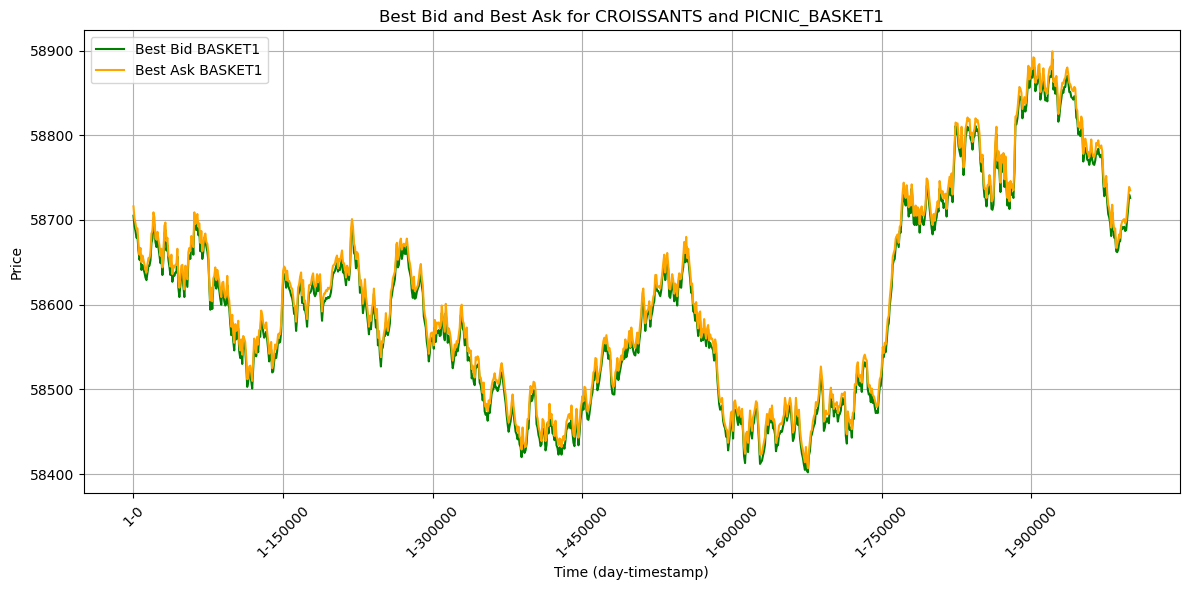

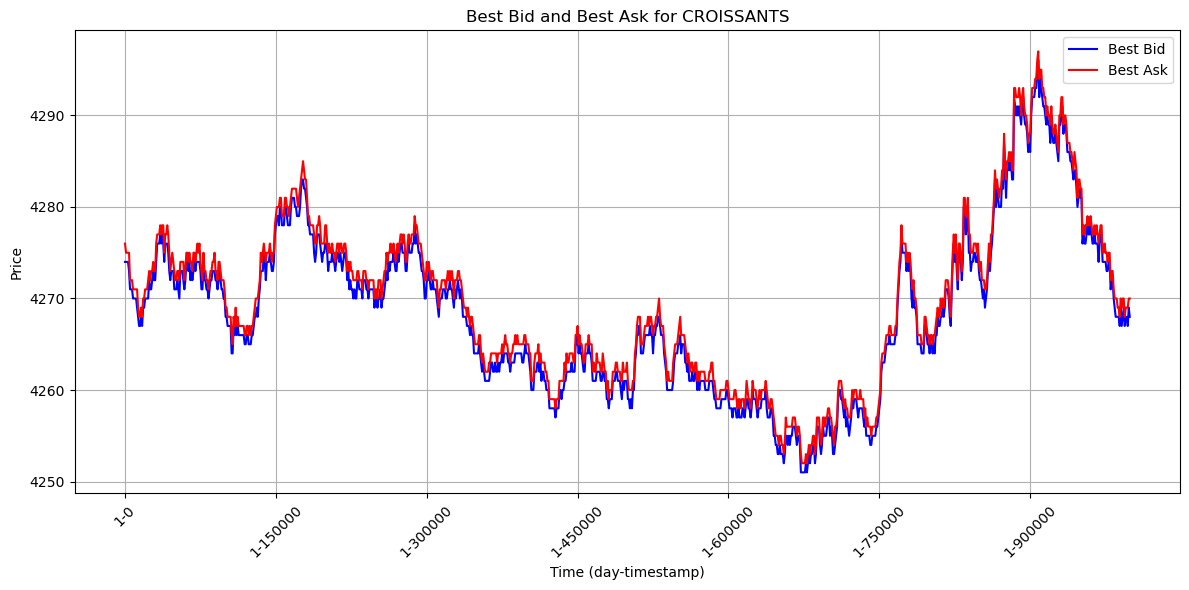

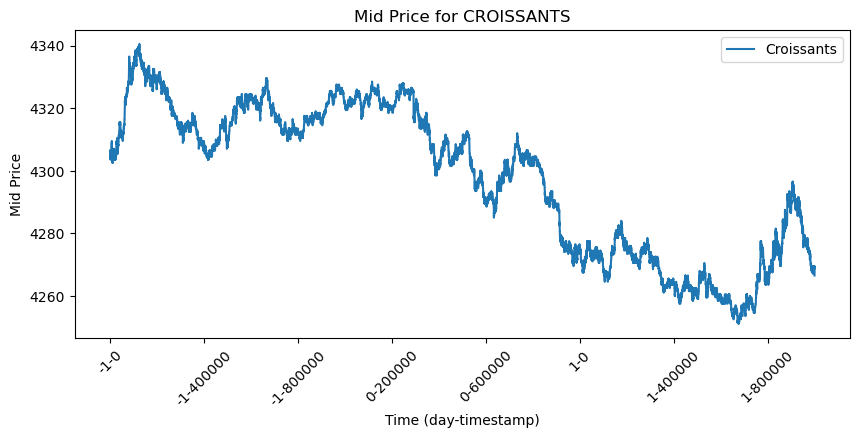

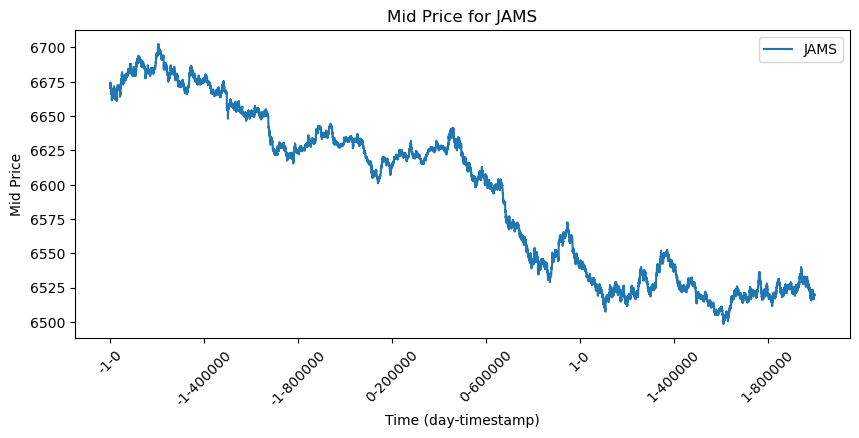

In [56]:
import matplotlib.ticker as ticker
def get_mid_price_series(df, product):
    sub = df[df['product'] == product][['day','timestamp','mid_price']].copy()
    # Create a combined time key (e.g. "day-timestamp"). You could also convert to a datetime if needed.
    sub['time'] = sub['day'].astype(str) + '-' + sub['timestamp'].astype(str)
    sub = sub.set_index('time')
    return sub['mid_price']

orders_df_sample = pd.read_csv('../data/round2/basket/prices_round_2_day_1.csv', delimiter=';')

mid_CROISSANTS   = get_mid_price_series(orders_df, 'CROISSANTS')
mid_JAMS         = get_mid_price_series(orders_df, 'JAMS')
mid_DJEMBES      = get_mid_price_series(orders_df, 'DJEMBES')
mid_PICNIC_BASKET1 = get_mid_price_series(orders_df, 'PICNIC_BASKET1')
mid_PICNIC_BASKET2 = get_mid_price_series(orders_df, 'PICNIC_BASKET2')


best_bid_croissants = get_best_bid_series(orders_df_sample, 'CROISSANTS')
best_ask_croissants = get_best_ask_series(orders_df_sample, 'CROISSANTS')
best_bid_BASKET1 = get_best_bid_series(orders_df_sample, 'PICNIC_BASKET1')
best_ask_BASKET1 = get_best_ask_series(orders_df_sample, 'PICNIC_BASKET1')



n = 10
best_bid_sample = best_bid_croissants.iloc[::n]
best_ask_sample = best_ask_croissants.iloc[::n]
best_ask_BASKET1_sample = best_ask_BASKET1.iloc[::n]
best_bid_BASKET1_sample = best_bid_BASKET1.iloc[::n]

plt.figure(figsize=(12,6))
plt.plot(best_bid_BASKET1_sample.index, best_bid_BASKET1_sample.values, label='Best Bid BASKET1', color='green', markersize=3)
plt.plot(best_ask_BASKET1_sample.index, best_ask_BASKET1_sample.values, label='Best Ask BASKET1', color='orange', markersize=3)
plt.xlabel('Time (day-timestamp)')
plt.ylabel('Price')
plt.title('Best Bid and Best Ask for CROISSANTS and PICNIC_BASKET1')
plt.legend()
# Limit x-axis ticks for clarity.
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(best_bid_sample.index, best_bid_sample.values, label='Best Bid', color='blue', markersize=3)
plt.plot(best_ask_sample.index, best_ask_sample.values, label='Best Ask', color='red', markersize=3)
plt.xlabel('Time (day-timestamp)')
plt.ylabel('Price')
plt.title('Best Bid and Best Ask for CROISSANTS')
plt.legend()

# Limit x-axis ticks for clarity.
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()



# (Optional) Plot one of them to check
plt.figure(figsize=(10,4))
plt.plot(mid_CROISSANTS.index, mid_CROISSANTS.values, label='Croissants')
plt.xticks(rotation=45)
plt.xlabel('Time (day-timestamp)')
plt.ylabel('Mid Price')
plt.title('Mid Price for CROISSANTS')
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(mid_JAMS.index, mid_JAMS.values, label='JAMS')
plt.xticks(rotation=45)
plt.xlabel('Time (day-timestamp)')
plt.ylabel('Mid Price')
plt.title('Mid Price for JAMS')
plt.legend()


# Set up the x-axis to show a limited number of ticks (e.g. 10)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
plt.xticks(rotation=45)
plt.show()


In [57]:
# Cell 4: Calculate theoretical fair values
# Using the given basket definitions:
# PICNIC_BASKET1 = 6 CROISSANTS + 3 JAMS + 1 DJEMBES
# PICNIC_BASKET2 = 4 CROISSANTS + 2 JAMS

# To ensure alignment, merge the series into one DataFrame on the index.
df_prices = pd.DataFrame({
    'Croissants': mid_CROISSANTS,
    'Jams': mid_JAMS,
    'Djembes': mid_DJEMBES,
    'Basket1': mid_PICNIC_BASKET1,
    'Basket2': mid_PICNIC_BASKET2
}).dropna()  # drop periods where any price is missing

# Calculate theoretical price for each basket
df_prices['Theo_Basket1'] = 6 * df_prices['Croissants'] + 3 * df_prices['Jams'] + 1 * df_prices['Djembes']
df_prices['Theo_Basket2'] = 4 * df_prices['Croissants'] + 2 * df_prices['Jams']

# Calculate spreads: actual basket price minus theoretical price
df_prices['Spread_Basket1'] = df_prices['Basket1'] - df_prices['Theo_Basket1']
df_prices['Spread_Basket2'] = df_prices['Basket2'] - df_prices['Theo_Basket2']

# Display a few rows
df_prices.head()


,Croissants,Jams,Djembes,Basket1,Basket2,Theo_Basket1,Theo_Basket2,Spread_Basket1,Spread_Basket2
time,,,,,,,,,
-1-0,4304.5,6670.5,13450.5,59289.0,30609.0,59289.0,30559.0,0.0,50.0
-1-100,4304.5,6670.5,13450.0,59287.0,30613.0,59288.5,30559.0,-1.5,54.0
-1-200,4304.5,6671.0,13450.5,59293.5,30615.0,59290.5,30560.0,3.0,55.0
-1-300,4304.5,6672.0,13450.0,59293.5,30620.5,59293.0,30562.0,0.5,58.5
-1-400,4305.5,6672.0,13452.5,59292.0,30621.0,59301.5,30566.0,-9.5,55.0


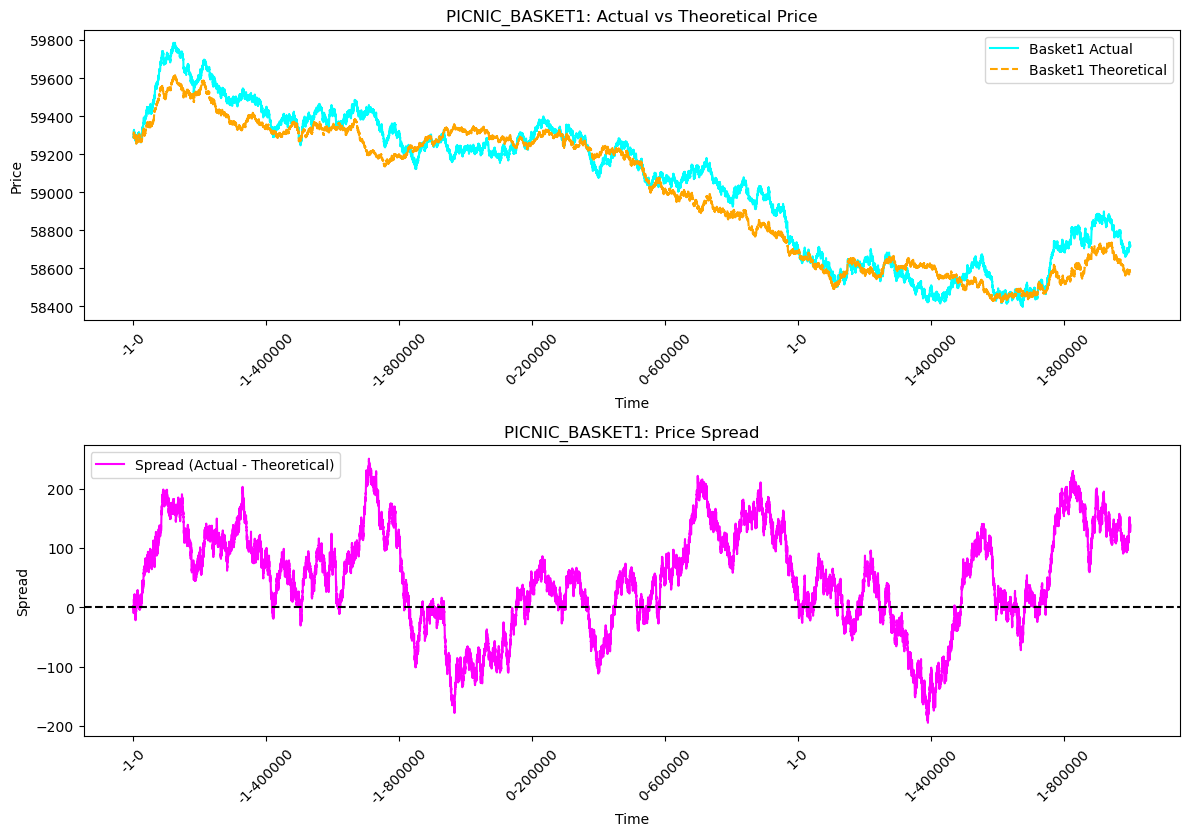

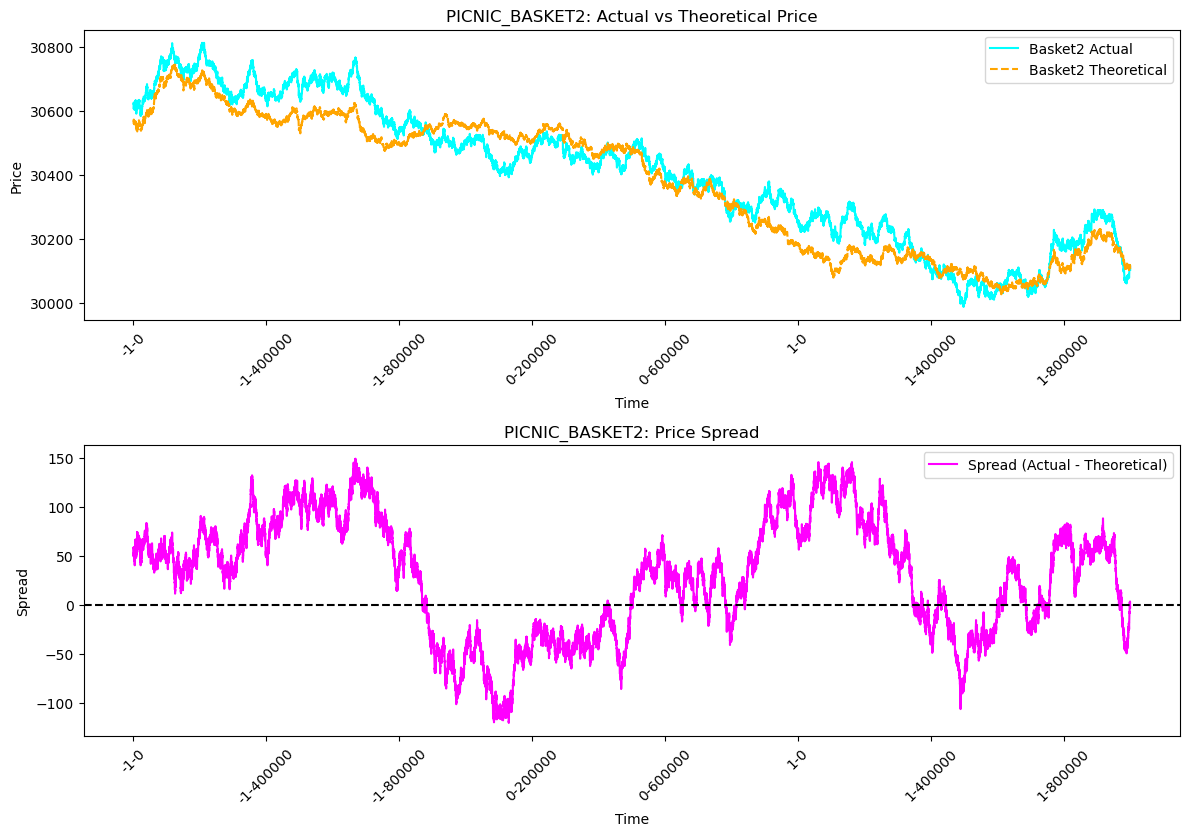

In [58]:

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(df_prices.index, df_prices['Basket1'], label='Basket1 Actual', color='cyan')
plt.plot(df_prices.index, df_prices['Theo_Basket1'], label='Basket1 Theoretical', linestyle='--', color='orange')
plt.title('PICNIC_BASKET1: Actual vs Theoretical Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
plt.xticks(rotation=45)


plt.subplot(2,1,2)
plt.plot(df_prices.index, df_prices['Spread_Basket1'], label='Spread (Actual - Theoretical)', color='magenta')
plt.axhline(0, color='black', linestyle='--')
plt.title('PICNIC_BASKET1: Price Spread')
plt.xlabel('Time')
plt.ylabel('Spread')
plt.legend()
plt.tight_layout()
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(df_prices.index, df_prices['Basket2'], label='Basket2 Actual', color='cyan')
plt.plot(df_prices.index, df_prices['Theo_Basket2'], label='Basket2 Theoretical', linestyle='--', color='orange')
plt.title('PICNIC_BASKET2: Actual vs Theoretical Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
plt.xticks(rotation=45)


plt.subplot(2,1,2)
plt.plot(df_prices.index, df_prices['Spread_Basket2'], label='Spread (Actual - Theoretical)', color='magenta')
plt.axhline(0, color='black', linestyle='--')
plt.title('PICNIC_BASKET2: Price Spread')
plt.xlabel('Time')
plt.ylabel('Spread')
plt.legend()
plt.tight_layout()
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
plt.xticks(rotation=45)
plt.show()


In [59]:
## run adfuller on the spread
adf_result_basket1 = adfuller(df_prices['Spread_Basket1'].dropna())
adf_result_basket2 = adfuller(df_prices['Spread_Basket2'].dropna())
print("ADF Test for PICNIC_BASKET1 Spread:")
print(f"Test Statistic: {adf_result_basket1[0]}")
print(f"p-value: {adf_result_basket1[1]}")
print(f"Critical Values: {adf_result_basket1[4]}")
print("\nADF Test for PICNIC_BASKET2 Spread:")
print(f"Test Statistic: {adf_result_basket2[0]}")
print(f"p-value: {adf_result_basket2[1]}")
print(f"Critical Values: {adf_result_basket2[4]}")

adf_basket1 = adfuller(df_prices['Basket1'].dropna())
adf_basket2 = adfuller(df_prices['Basket2'].dropna())
print("\nADF Test for PICNIC_BASKET1:")
print(f"Test Statistic: {adf_basket1[0]}")
print(f"p-value: {adf_basket1[1]}")
print(f"Critical Values: {adf_basket1[4]}")
print("\nADF Test for PICNIC_BASKET2:")
print(f"Test Statistic: {adf_basket2[0]}")
print(f"p-value: {adf_basket2[1]}")
print(f"Critical Values: {adf_basket2[4]}")

# Hurst exponent for the spread
hurst_basket1 = hurst_exponent(df_prices['Spread_Basket1'].dropna().values)
hurst_basket2 = hurst_exponent(df_prices['Spread_Basket2'].dropna().values)
print(f"Hurst Exponent for PICNIC_BASKET1 Spread: {hurst_basket1:.4f}")
print(f"Hurst Exponent for PICNIC_BASKET2 Spread: {hurst_basket2:.4f}")
# Hurst exponent for the baskets
hurst_basket1 = hurst_exponent(df_prices['Basket1'].dropna().values)
hurst_basket2 = hurst_exponent(df_prices['Basket2'].dropna().values)
print(f"Hurst Exponent for PICNIC_BASKET1: {hurst_basket1:.4f}")
print(f"Hurst Exponent for PICNIC_BASKET2: {hurst_basket2:.4f}")



ADF Test for PICNIC_BASKET1 Spread:
Test Statistic: -3.1801849996300504
p-value: 0.021160682756257664
Critical Values: {'1%': np.float64(-3.4305680243931267), '5%': np.float64(-2.861636360888007), '10%': np.float64(-2.5668212899601888)}

ADF Test for PICNIC_BASKET2 Spread:
Test Statistic: -2.7422083620078284
p-value: 0.06701480341329635
Critical Values: {'1%': np.float64(-3.4305680243931267), '5%': np.float64(-2.861636360888007), '10%': np.float64(-2.5668212899601888)}

ADF Test for PICNIC_BASKET1:
Test Statistic: -0.8832890251707707
p-value: 0.7934257585902266
Critical Values: {'1%': np.float64(-3.43056803166244), '5%': np.float64(-2.861636364100729), '10%': np.float64(-2.566821291670243)}

ADF Test for PICNIC_BASKET2:
Test Statistic: -0.7850019540183095
p-value: 0.8234879813568619
Critical Values: {'1%': np.float64(-3.43056803166244), '5%': np.float64(-2.861636364100729), '10%': np.float64(-2.566821291670243)}
Hurst Exponent for PICNIC_BASKET1 Spread: 0.9459
Hurst Exponent for PICNIC

In [60]:
from statsmodels.tsa.stattools import coint

basket1 = df_prices['Basket1'].dropna()
basket2 = df_prices['Basket2'].dropna()


combined = pd.concat([basket1, basket2], axis=1).dropna()
combined.columns = ['Basket1', 'Basket2']

# --- Step 2: Regress Basket1 on Basket2 using OLS ---
# Add constant term for the intercept.
X = sm.add_constant(combined['Basket2'])
model = sm.OLS(combined['Basket1'], X).fit()
residuals = model.resid

print("OLS Regression Results:")
print(model.summary())

# --- Step 3: Run ADF Test on Residuals ---
adf_resid = adfuller(residuals)
print("\nADF Test on Residuals (Cointegration Test):")
print(f"Test Statistic: {adf_resid[0]}")
print(f"p-value: {adf_resid[1]}")
print(f"Critical Values: {adf_resid[4]}")

# If the p-value is low (< 0.05), then the residuals are stationary, implying cointegration.

# Alternatively, run the built-in cointegration test:
score, pvalue, _ = coint(combined['Basket1'], combined['Basket2'])
print("\nEngle-Granger Cointegration Test (statsmodels.coint):")
print(f"Cointegration test p-value: {pvalue}")

# Interpretation:
# If the p-value from either the ADF test on residuals or the coint function is below your significance threshold,
# then you can conclude that the baskets are cointegrated (i.e. their linear combination is I(0)).


OLS Regression Results:
                            OLS Regression Results                            
Dep. Variable:                Basket1   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                 3.179e+05
Date:                Sat, 12 Apr 2025   Prob (F-statistic):               0.00
Time:                        17:38:10   Log-Likelihood:            -1.8269e+05
No. Observations:               30000   AIC:                         3.654e+05
Df Residuals:                   29998   BIC:                         3.654e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9878.0788     87

In [61]:
import scipy.stats as stats

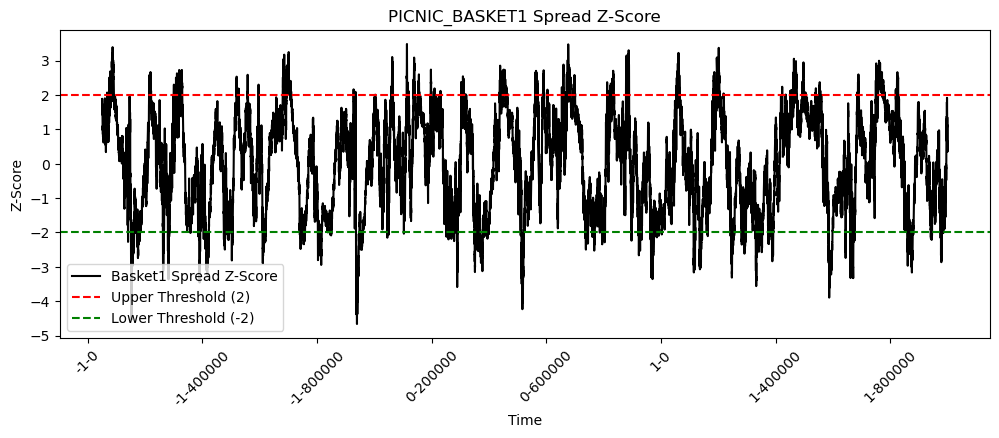

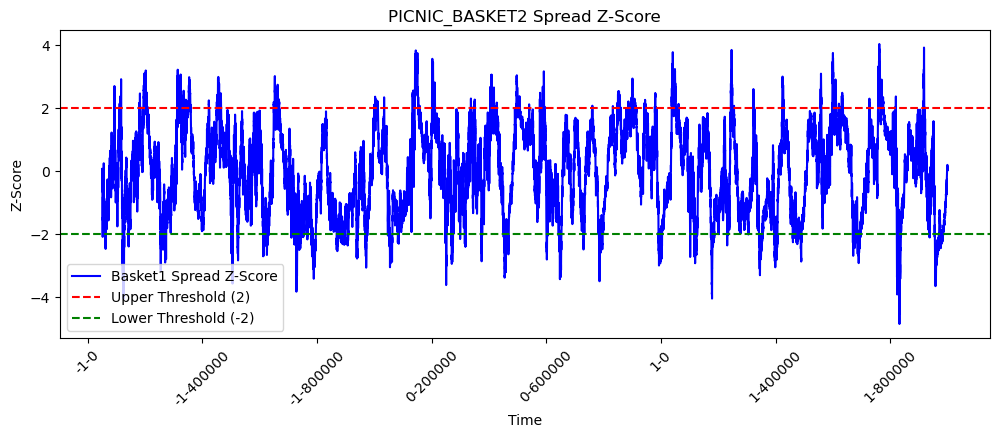

In [62]:
# Cell 6: Calculate rolling z-score of the spread (using a 50-period window)
window = 500
df_prices['Zscore_Basket1'] = rolling_zscore(df_prices['Spread_Basket1'], window)
df_prices['Zscore_Basket2'] = rolling_zscore(df_prices['Spread_Basket2'], window)

# Plot the Z-score for Basket1
plt.figure(figsize=(12,4))
plt.plot(df_prices.index, df_prices['Zscore_Basket1'], label='Basket1 Spread Z-Score', color='black')
plt.axhline(2, color='red', linestyle='--', label='Upper Threshold (2)')
plt.axhline(-2, color='green', linestyle='--', label='Lower Threshold (-2)')
plt.title('PICNIC_BASKET1 Spread Z-Score')
plt.xlabel('Time')
plt.ylabel('Z-Score')
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(df_prices.index, df_prices['Zscore_Basket2'], label='Basket1 Spread Z-Score', color='blue')
plt.axhline(2, color='red', linestyle='--', label='Upper Threshold (2)')
plt.axhline(-2, color='green', linestyle='--', label='Lower Threshold (-2)')
plt.title('PICNIC_BASKET2 Spread Z-Score')
plt.xlabel('Time')
plt.ylabel('Z-Score')
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
plt.xticks(rotation=45)
plt.show()


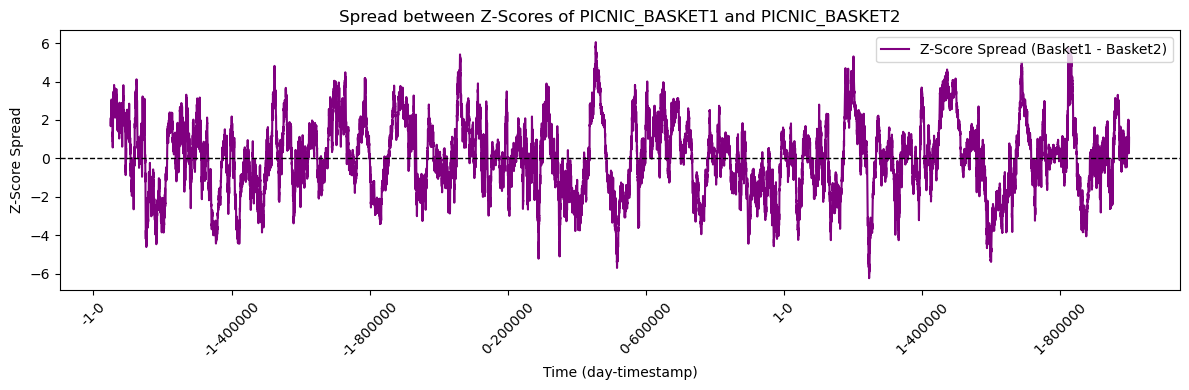

In [79]:
df_prices['Zscore_Spread'] = df_prices['Zscore_Basket1'] - df_prices['Zscore_Basket2']

# Plot the Z-score spread.
plt.figure(figsize=(12,4))
plt.plot(df_prices.index, df_prices['Zscore_Spread'], label="Z-Score Spread (Basket1 - Basket2)", 
         color="purple", linewidth=1.5)
plt.axhline(0, color="black", linestyle="--", linewidth=1)  # zero line for reference
plt.xlabel('Time (day-timestamp)')
plt.ylabel('Z-Score Spread')
plt.title('Spread between Z-Scores of PICNIC_BASKET1 and PICNIC_BASKET2')
plt.legend(loc="upper right")

# Limit the number of x-axis ticks to keep the chart uncluttered.
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [63]:
### run adfuller on the z-score spread
adf_result_zscore_basket1 = adfuller(df_prices['Zscore_Basket1'].dropna())
adf_result_zscore_basket2 = adfuller(df_prices['Zscore_Basket2'].dropna())
print("ADF Test for PICNIC_BASKET1 Z-Score Spread:")
print(f"Test Statistic: {adf_result_zscore_basket1[0]}")
print(f"p-value: {adf_result_zscore_basket1[1]}")
print(f"Critical Values: {adf_result_zscore_basket1[4]}")
print("\nADF Test for PICNIC_BASKET2 Z-Score Spread:")
print(f"Test Statistic: {adf_result_zscore_basket2[0]}")
print(f"p-value: {adf_result_zscore_basket2[1]}")
print(f"Critical Values: {adf_result_zscore_basket2[4]}")

zscore_basket1 = df_prices['Zscore_Basket1'].dropna().values
zscore_basket2 = df_prices['Zscore_Basket2'].dropna().values

# Now compute the Hurst exponent for each zscore series:
H_basket1 = hurst_exponent(zscore_basket1)
H_basket2 = hurst_exponent(zscore_basket2)

print("Hurst Exponent for Basket1 Z-score Spread: {:.4f}".format(H_basket1))
print("Hurst Exponent for Basket2 Z-score Spread: {:.4f}".format(H_basket2))



ADF Test for PICNIC_BASKET1 Z-Score Spread:
Test Statistic: -9.08419403856286
p-value: 3.980974171674631e-15
Critical Values: {'1%': np.float64(-3.4305717130272946), '5%': np.float64(-2.861637991103707), '10%': np.float64(-2.5668221576848502)}

ADF Test for PICNIC_BASKET2 Z-Score Spread:
Test Statistic: -9.607207917072627
p-value: 1.8524273107034887e-16
Critical Values: {'1%': np.float64(-3.430571705510435), '5%': np.float64(-2.8616379877815845), '10%': np.float64(-2.566822155916564)}
Hurst Exponent for Basket1 Z-score Spread: 0.8764
Hurst Exponent for Basket2 Z-score Spread: 0.8904


In [64]:

spread_series = df_prices['Spread_Basket1'].dropna()

# Augmented Dickey-Fuller Test
adf_result = adfuller(spread_series)
adf_stat, adf_pvalue = adf_result[0], adf_result[1]
print("ADF Statistic for Basket1 Spread: {:.4f}".format(adf_stat))
print("ADF p-value for Basket1 Spread: {:.4f}".format(adf_pvalue))

# Hurst Exponent
H = hurst_exponent(spread_series.values)
print("Hurst Exponent for Basket1 Spread: {:.4f}".format(H))

# Half-life estimation using the simple regression method:
def half_life_estimate(spread):
    spread_lag = spread.shift(1).dropna()
    delta_spread = spread.diff().dropna()
    # Align the series (they will have one less observation)
    spread_lag = spread_lag.loc[delta_spread.index]
    beta = np.polyfit(spread_lag, delta_spread, 1)[0]
    if beta >= 0:
        return np.nan  # if no mean reversion is detected
    half_life = -np.log(2) / beta
    return half_life

hl = half_life_estimate(df_prices['Spread_Basket1'])
print("Estimated Half-Life for Basket1 Spread: {:.2f} periods".format(hl))

## Basket 2
spread_series2 = df_prices['Spread_Basket2'].dropna()

# Augmented Dickey-Fuller Test
adf_result = adfuller(spread_series2)
adf_stat, adf_pvalue = adf_result[0], adf_result[1]
print("ADF Statistic for Basket2 Spread: {:.4f}".format(adf_stat))
print("ADF p-value for Basket2 Spread: {:.4f}".format(adf_pvalue))

# Hurst Exponent
H = hurst_exponent(spread_series2.values)
print("Hurst Exponent for Basket2 Spread: {:.4f}".format(H))

# Half-life estimation using the simple regression method:
def half_life_estimate(spread):
    spread_lag = spread.shift(1).dropna()
    delta_spread = spread.diff().dropna()
    # Align the series (they will have one less observation)
    spread_lag = spread_lag.loc[delta_spread.index]
    beta = np.polyfit(spread_lag, delta_spread, 1)[0]
    if beta >= 0:
        return np.nan  # if no mean reversion is detected
    half_life = -np.log(2) / beta
    return half_life

hl = half_life_estimate(df_prices['Spread_Basket2'])
print("Estimated Half-Life for Basket2 Spread: {:.2f} periods".format(hl))



ADF Statistic for Basket1 Spread: -3.1802
ADF p-value for Basket1 Spread: 0.0212
Hurst Exponent for Basket1 Spread: 0.9459
Estimated Half-Life for Basket1 Spread: 695.17 periods
ADF Statistic for Basket2 Spread: -2.7422
ADF p-value for Basket2 Spread: 0.0670
Hurst Exponent for Basket2 Spread: 0.9404
Estimated Half-Life for Basket2 Spread: 941.97 periods


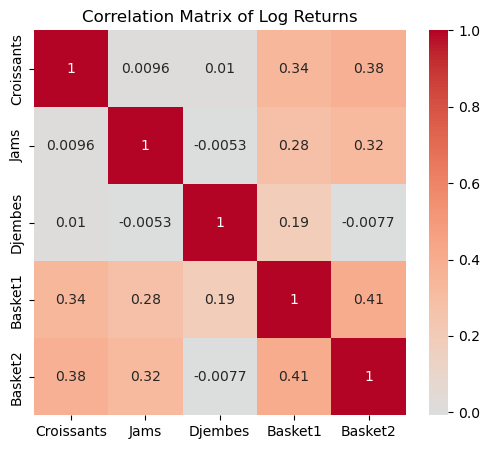

In [65]:

# Compute log returns (or percentage returns) for each product
df_returns = np.log(df_prices[['Croissants','Jams','Djembes','Basket1','Basket2']]).diff().dropna()
corr_matrix = df_returns.corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Log Returns')
plt.show()


In [66]:
#Estimate an upper bound for returns with perfect foresight for Basket1.
# This simplified version finds local minima and maxima in the spread.
from scipy.signal import find_peaks

# Find peaks (local maxima) and troughs (local minima) in the spread of Basket1
spread_vals = df_prices['Spread_Basket1'].dropna().values
peaks, _ = find_peaks(spread_vals)
troughs, _ = find_peaks(-spread_vals)

# For simplicity, assume we can trade between each consecutive trough and peak.
# Sum up the absolute differences as an ideal profit.
# (Make sure the first extreme is a trough and then a peak, else adjust accordingly.)
if troughs.size > 0 and peaks.size > 0:
    # Simple pairing; note that more robust pairing is possible.
    ideal_profits = []
    i_peak = 0
    for t in troughs:
        # Find the next peak index greater than trough index
        next_peaks = peaks[peaks > t]
        if len(next_peaks) > 0:
            p = next_peaks[0]
            profit = spread_vals[p] - spread_vals[t]
            ideal_profits.append(profit)
    total_ideal_profit = np.sum(ideal_profits)
    print("Total Idealised Profit for Basket1 (perfect foresight): {:.2f}".format(total_ideal_profit))
else:
    print("Insufficient peaks/troughs detected to compute ideal profit.")

spread_vals2 = df_prices['Spread_Basket2'].dropna().values
peaks, _ = find_peaks(spread_vals2)
troughs, _ = find_peaks(-spread_vals2)


if troughs.size > 0 and peaks.size > 0:
    ideal_profits = []
    i_peak = 0
    for t in troughs:
        # Find the next peak index greater than trough index
        next_peaks = peaks[peaks > t]
        if len(next_peaks) > 0:
            p = next_peaks[0]
            profit = spread_vals2[p] - spread_vals2[t]
            ideal_profits.append(profit)
    total_ideal_profit = np.sum(ideal_profits)
    print("Total Idealised Profit for Basket2 (perfect foresight): {:.2f}".format(total_ideal_profit))
else:
    print("Insufficient peaks/troughs detected to compute ideal profit.")


Total Idealised Profit for Basket1 (perfect foresight): 45621.00
Total Idealised Profit for Basket2 (perfect foresight): 27306.00


## Jomama test

In [77]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# df_prices['Theo_Basket1'] = 6 * df_prices['Croissants'] + 3 * df_prices['Jams'] + 1 * df_prices['Djembes']
# df_prices['Theo_Basket2'] = 4 * df_prices['Croissants'] + 2 * df_prices['Jams']

prices = df_prices[['Spread_Basket1', 'Spread_Basket2']].dropna()

johansen = coint_johansen(prices, det_order=0, k_ar_diff=1)
print("Johansen Cointegration Test Results for Basket Prices:")
for i, trace_stat in enumerate(johansen.lr1):
    cv = johansen.cvt[i]  # critical values for 90%, 95%, and 99%
    print(f"Cointegration Rank <= {i}: Trace Statistic = {trace_stat:.4f}, Critical Values = {cv}")

# Print the cointegrating vectors (eigenvectors).
print("\nCointegrating Vectors (Eigenvectors):")
# Each column in johansen_result.evec corresponds to a cointegrating relation.
for i in range(johansen.evec.shape[1]):
    # Optionally, normalize by setting the first coefficient to 1 if desired:
    vec = johansen.evec[:, i]
    # For instance, if we normalize the first element to 1:
    if vec[0] != 0:
        vec_norm = vec / vec[0]
    else:
        vec_norm = vec
    print(f"Relation {i+1}: {vec_norm}")

Johansen Cointegration Test Results for Basket Prices:
Cointegration Rank <= 0: Trace Statistic = 23.6477, Critical Values = [13.4294 15.4943 19.9349]
Cointegration Rank <= 1: Trace Statistic = 7.7040, Critical Values = [2.7055 3.8415 6.6349]

Cointegrating Vectors (Eigenvectors):
Relation 1: [ 1.         -1.08334861]
Relation 2: [1.         2.87900787]


In [78]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# df_prices['Theo_Basket1'] = 6 * df_prices['Croissants'] + 3 * df_prices['Jams'] + 1 * df_prices['Djembes']
# df_prices['Theo_Basket2'] = 4 * df_prices['Croissants'] + 2 * df_prices['Jams']

prices = df_prices[['Zscore_Basket1', 'Zscore_Basket2']].dropna()

johansen = coint_johansen(prices, det_order=0, k_ar_diff=1)
print("Johansen Cointegration Test Results for Basket Prices:")
for i, trace_stat in enumerate(johansen.lr1):
    cv = johansen.cvt[i]  # critical values for 90%, 95%, and 99%
    print(f"Cointegration Rank <= {i}: Trace Statistic = {trace_stat:.4f}, Critical Values = {cv}")

# Print the cointegrating vectors (eigenvectors).
print("\nCointegrating Vectors (Eigenvectors):")
# Each column in johansen_result.evec corresponds to a cointegrating relation.
for i in range(johansen.evec.shape[1]):
    # Optionally, normalize by setting the first coefficient to 1 if desired:
    vec = johansen.evec[:, i]
    # For instance, if we normalize the first element to 1:
    if vec[0] != 0:
        vec_norm = vec / vec[0]
    else:
        vec_norm = vec
    print(f"Relation {i+1}: {vec_norm}")

Johansen Cointegration Test Results for Basket Prices:
Cointegration Rank <= 0: Trace Statistic = 188.3012, Critical Values = [13.4294 15.4943 19.9349]
Cointegration Rank <= 1: Trace Statistic = 89.5916, Critical Values = [2.7055 3.8415 6.6349]

Cointegrating Vectors (Eigenvectors):
Relation 1: [  1.         -42.87119529]
Relation 2: [ 1.        -0.0679926]


In [81]:
from pymle.models import GeometricBM, OrnsteinUhlenbeck
from pymle.core.TransitionDensity import KesslerDensity, ShojiOzakiDensity
from pymle.fit.AnalyticalMLE import AnalyticalMLE

In [85]:
df = df_prices['Zscore_Spread'].dropna()
print(df)
sample = df.values

model = OrnsteinUhlenbeck()


time
-1-49900    1.871613
-1-50000    1.676534
-1-50100    2.013420
-1-50200    2.090186
-1-50300    2.068952
              ...   
1-999500    0.359556
1-999600    0.491980
1-999700    0.277750
1-999800    0.835236
1-999900    1.074429
Name: Zscore_Spread, Length: 29501, dtype: float64


In [86]:
param_bounds = [(0.0, 10000), (0.0, 10000), (0.0, 10000)]
guess = np.array([df.mean(), 0.1, 0.1])
dt = 100
kessler_est = AnalyticalMLE(sample, param_bounds, dt, density=KesslerDensity(model)).estimate_params(guess)

print(f'\nKessler MLE: {kessler_est} \n')

shojioz_est = AnalyticalMLE(sample, param_bounds, dt, density=ShojiOzakiDensity(model)).estimate_params(guess)

print(f'\nShoji-Ozaki MLE: {shojioz_est}')

Initial Params: [0.02185072 0.1        0.1       ]
Initial Likelihood: -58435.20015987074
`gtol` termination condition is satisfied.
Number of iterations: 66, function evaluations: 244, CG iterations: 142, optimality: 2.33e-07, constraint violation: 0.00e+00, execution time: 0.27 s.
Final Params: [6.70580903e-05 1.80352608e-02 2.18076742e-02]
Final Likelihood: 3066.764338443009

Kessler MLE: 
params      | [6.70580903e-05 1.80352608e-02 2.18076742e-02] 
sample size | 29500 
likelihood  | 3066.764338443009 
AIC         | -6127.528676886018
BIC         | -6102.652240259034 

Initial Params: [0.02185072 0.1        0.1       ]
Initial Likelihood: -189686.63217842963
`xtol` termination condition is satisfied.
Number of iterations: 87, function evaluations: 328, CG iterations: 175, optimality: 7.15e-01, constraint violation: 0.00e+00, execution time: 0.38 s.
Final Params: [6.60451500e-05 2.62248123e-01 2.18805616e-02]
Final Likelihood: 3065.9507672379705

Shoji-Ozaki MLE: 
params      | [6.6